# Synthesize Underway data from multi-files

There are two flavors of underway data:
- SaMOS which is maintained by FSU and submitted from the NOAA Vessels
    + assume some measure of correction, averaging, calibration
- EcoFOCI which is usually our own datalogger and gear
    + must provide collocated measurements, averaging and calibration (or field check)
    + **Assumptions**
        - 1min averages
        - Temp, Salinity, and Position (SOG,COG) so far

In [345]:
import pandas as pd
import numpy as np
import os
import datetime

In [346]:
path_to_underway = '/Users/bell/ecoraid/2019/AlongTrack/os1901l3/raw/'

list_subdirs = os.listdir(path_to_underway)
list_subdirs

['GPS', 'eco', 'optode', 'sbe48', 'tsg', 'tdgp']

## Temperature and Salinity

In [347]:
#tsg
tsg_names=['time','temperature','conductivity','salinity']
all_files = os.listdir(path_to_underway+'tsg/')

big_df=pd.DataFrame()

for file_ in sorted(all_files):
    df = pd.read_csv(path_to_underway+'tsg/'+file_,parse_dates=True, header=None, names=tsg_names,error_bad_lines=False)
    big_df = pd.concat([big_df,df],ignore_index=True)

big_df.set_index(pd.DatetimeIndex(big_df['time']),inplace=True)
big_df.drop(labels=['time'],axis=1,inplace=True)

<AxesSubplot:ylabel='Frequency'>

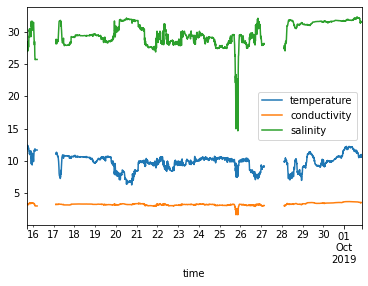

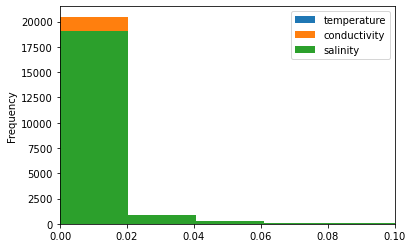

In [348]:
big_df_tsg = big_df.resample('T').mean()
big_df_tsg.plot()
big_df.resample('T').std().plot(kind='hist',bins=100,xlim=[0,.1])

### very crude filter

through out any 1min sample where the std deviation is .5 deg for temp and .1 for psu

In [349]:
filter=False

if filter:
    big_df_tsg['temperature'][big_df.resample('T').std().temperature>.5] = np.nan
    big_df_tsg['salinity'][big_df.resample('T').std().salinity>.1] = np.nan
else:
    big_df_tsg=big_df.resample('T').mean()

In [350]:
big_df_tsg.sample()

,temperature,conductivity,salinity
time,,,
2019-09-19 22:45:00,9.258817,3.206202,29.508283


## GPS

In [351]:
#GPRMC - Location, COG, SOG, time
all_files = os.listdir(path_to_underway+'GPS/')

GPSdata= []

for file_ in sorted(all_files):
    with open(path_to_underway+'GPS/'+file_, "r") as f:
        print(file_)
        for line in f.readlines():
            if 'GPRMC' in line:
                GPSdata.append(line.split(','))


2019-09-15T0440Z_os1901_leg3_GPS_raw.dat
2019-09-15T1702Z_os1901_leg3_GPS_raw.dat
2019-09-16T0000Z_os1901_leg3_GPS_raw.dat
2019-09-17T0227Z_os1901_leg3_GPS_raw.dat
2019-09-18T0000Z_os1901_leg3_GPS_raw.dat
2019-09-19T0000Z_os1901_leg3_GPS_raw.dat
2019-09-20T0000Z_os1901_leg3_GPS_raw.dat
2019-09-21T0000Z_os1901_leg3_GPS_raw.dat
2019-09-22T0000Z_os1901_leg3_GPS_raw.dat
2019-09-23T0000Z_os1901_leg3_GPS_raw.dat
2019-09-24T0000Z_os1901_leg3_GPS_raw.dat
2019-09-24T2118Z_os1901_leg3_GPS_raw.dat
2019-09-25T0000Z_os1901_leg3_GPS_raw.dat
2019-09-26T0000Z_os1901_leg3_GPS_raw.dat
2019-09-27T0000Z_os1901_leg3_GPS_raw.dat
2019-09-28T0236Z_os1901_leg3_GPS_raw.dat
2019-09-29T0000Z_os1901_leg3_GPS_raw.dat
2019-09-30T0000Z_os1901_leg3_GPS_raw.dat
2019-10-01T0000Z_os1901_leg3_GPS_raw.dat


In [352]:
GPS_df = pd.DataFrame(GPSdata,columns=['PC time','Message ID','UTC time',
                              'status','latitude','lat hemi',
                              'longitude','lon hemi','sog','cog',
                              'date','mag var','mode_checksum'])

### Parse and clean the gps

In [353]:
#convert gps time
GPS_df['GPS time']=np.nan
GPS_df['GPS time'] =GPS_df.apply(lambda x: datetime.datetime.strptime(x['date']+' '+x['UTC time'],'%d%m%y %H%M%S'), axis=1)

In [354]:
#drop unneeded anc values
GPS_df.drop(labels=['Message ID','UTC time','status','mode_checksum','date'],axis=1,inplace=True)

In [355]:
#calculate lat/lon
#replace W,S with -1
GPS_df['lat hemi'][GPS_df['lat hemi'] == 'N'] = 1
GPS_df['lat hemi'][GPS_df['lat hemi'] == 'S'] = -1
GPS_df['lon hemi'][GPS_df['lon hemi'] == 'E'] = 1
GPS_df['lon hemi'][GPS_df['lon hemi'] == 'W'] = -1

<ipython-input-355-240eb6c69453>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPS_df['lat hemi'][GPS_df['lat hemi'] == 'N'] = 1
<ipython-input-355-240eb6c69453>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPS_df['lat hemi'][GPS_df['lat hemi'] == 'S'] = -1
<ipython-input-355-240eb6c69453>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPS_df['lon hemi'][GPS_df['lon hemi'] == 'E'] = 1
<ipython-input-355-240eb6c69453>:6: Settin

In [356]:
GPS_df['lat']= GPS_df.apply(lambda x: (float(x['latitude'][:2])+float(x['latitude'][2:])/60) * float(x['lat hemi']), axis=1)
GPS_df['lon']= GPS_df.apply(lambda x: (float(x['longitude'][:3])+float(x['longitude'][3:])/60) * float(x['lon hemi']), axis=1)

In [357]:
GPS_df.sample()

,PC time,latitude,lat hemi,longitude,lon hemi,sog,cog,mag var,GPS time,lat,lon
845105,2019-09-25T22:23:08,6648.3150,1,16333.1517,-1,9.3,258.9,12.9,2019-09-25 22:17:56,66.80525,-163.552528


In [358]:
GPS_df.drop(labels=['latitude','lat hemi','longitude','lon hemi'],axis=1,inplace=True)

In [359]:
GPS_df.set_index(pd.DatetimeIndex(GPS_df['PC time']),inplace=True)

In [360]:
GPS_df=GPS_df.astype({'cog': 'float', 'sog': 'float','mag var': 'float'},errors='ignore')

a mean or average will drop the gps time ... and its already a questionable thing to average over space... so lets just decimate to pc time... once all the parameters are lined up... we can correct to gps time and then resample linearly?

In [361]:
big_df_gps=GPS_df.resample('1t').first()

## Oxygen Sensor (Optode + temp)

In [362]:
#tsg
optode_names=['time','oxy_concentration','oxy_saturation','oxy_temperature']
all_files = os.listdir(path_to_underway+'optode/')

big_df=pd.DataFrame()

for file_ in sorted(all_files):
    df = pd.read_csv(path_to_underway+'optode/'+file_,parse_dates=True, header=None, delimiter='\t',
                     names=optode_names,usecols=[0,2,3,4],error_bad_lines=False)
    big_df = pd.concat([big_df,df],ignore_index=True)

big_df.set_index(pd.DatetimeIndex(big_df['time']),inplace=True)
big_df.drop(labels=['time'],axis=1,inplace=True)

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname F identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [363]:
big_df_oxy=big_df.resample('T').mean()

## Merge sampled dataframes (at 1min)

In [364]:
bigcruise_df = pd.concat([big_df_gps,big_df_tsg,big_df_oxy])

In [365]:
merge_temp=pd.merge(big_df_gps.tz_localize(tz='UTC'),big_df_tsg.tz_localize(tz='UTC'), how='inner', left_index=True, right_index=True)
bigcruise_df=pd.merge(merge_temp,big_df_oxy.tz_localize(tz='UTC'), how='inner', left_index=True, right_index=True)

In [366]:
bigcruise_df.to_csv('OS1901L3_1min.csv')

In [367]:
bigcruise_df.sample()

,PC time,sog,cog,mag var,GPS time,lat,lon,temperature,conductivity,salinity,oxy_concentration,oxy_saturation,oxy_temperature
2019-09-21 18:34:00+00:00,2019-09-21T18:34:00,5.1,107.4,11.7,2019-09-21 18:31:13,68.015647,-165.903315,9.296083,3.001907,27.4089,337.3595,93.954,9.233


## Plot an example of the data saved via cartopy or holoviews

In [368]:
import xarray as xa
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

In [369]:
#topo if wanted
server_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSS111'
extent=[-179.5, -150, 52.5, 80]

bathy = xa.open_dataset(server_url) 
bathy_sub = bathy.sel(latitude=slice(extent[3],extent[2]),longitude=slice(extent[0],extent[1]))


def make_map(projection=ccrs.PlateCarree()):
    """subroutine to specify basemap"""
    fig, ax = plt.subplots(figsize=(12,12),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

#make maps
def plot_data(variable,latitude,longitude,extent):
    projection=ccrs.LambertConformal(central_longitude=-160.0)
    transformation=ccrs.PlateCarree()

    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                    edgecolor='face',
                                                    facecolor='1.0')

    fig,ax = make_map(projection=projection)

    try:
        c = ax.scatter(longitude, latitude, s=10,
                   c=(variable), cmap=cmocean.cm.balance,
                   vmin=min(variable), vmax=max(variable),
                   transform=transformation)
    except:
        pass
    plt.colorbar(c)
    ax.add_feature(land_50m)
    ax.coastlines(resolution='10m')
    ax.set_extent(extent)
    
    return(fig,ax)


(<Figure size 864x864 with 2 Axes>, <GeoAxesSubplot:>)

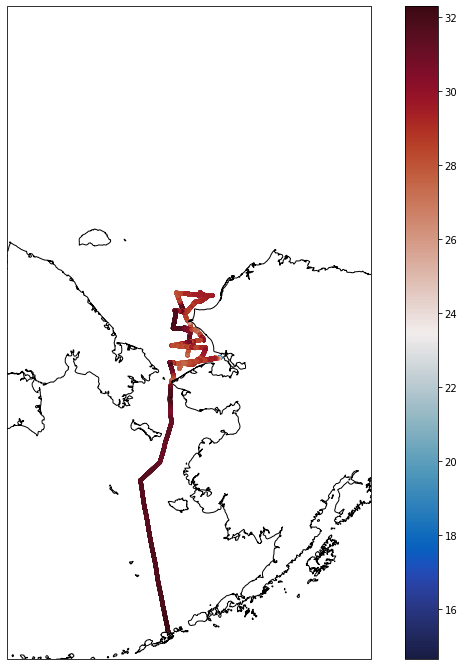

In [370]:
plot_data(bigcruise_df.salinity,bigcruise_df.lat,bigcruise_df.lon,extent)

## Compare to CTD casts near sfc (via erddap)

In [371]:
from erddapy import ERDDAP

#search and boundary parameters

server_url = 'http://akutan.pmel.noaa.gov:8080/erddap/'

deployments = []

constraints = {
    'time>=': '1995-01-01T00:00:00Z',
    'time<=': datetime.datetime.utcnow().strftime('%Y-%m-%dT00:00:00Z'),
    'pressure>=': 0,
    'pressure<=': 0,
}

variables = ['latitude, longitude, S_41, S_42, T_28, T2_35, time, pressure']

dataset_id='CTD_os1901l3_final'
print(dataset_id)

d = ERDDAP(server=server_url,
    protocol='tabledap',
    response='csv'
)
d.dataset_id=dataset_id
d.variables = variables
d.constraints = constraints

df_m = d.to_pandas(
            index_col='time (UTC)',
            parse_dates=True,
            skiprows=(1,)  # units information can be dropped.
            )
df_m.sort_index(inplace=True)
df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]

#-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
#and some 1e35 are off a bit
df_m['pressure'][(df_m.pressure == -9999)] = np.nan # only in pressure field

#match on time after converting to nearest minute
df_ctd = df_m.resample('1T').first().dropna()

CTD_os1901l3_final


In [372]:
underway_ctd = pd.merge(bigcruise_df,df_ctd, how='inner', left_index=True, right_index=True)

In [373]:
underway_ctd

,PC time,sog,cog,mag var,GPS time,lat,lon,temperature,conductivity,salinity,oxy_concentration,oxy_saturation,oxy_temperature,latitude,longitude,S_41,S_42,T_28,T2_35,pressure
2019-09-17 21:10:00+00:00,2019-09-17T21:10:00,0.9,152.7,11.2,2019-09-17 21:09:30,69.500810,-167.098588,10.677617,3.288982,29.184467,327.2040,94.1065,10.5955,69.499830,192.90350,29.4193,29.4206,10.2394,10.2389,0.0
2019-09-18 16:49:00+00:00,2019-09-18T16:49:00,0.9,261.7,12.0,2019-09-18 16:48:01,69.493675,-165.738355,10.504700,3.300908,29.440783,324.9775,93.0845,10.4205,69.493330,194.25783,29.6896,29.6920,10.1071,10.1039,0.0
2019-09-18 22:38:00+00:00,2019-09-18T22:38:00,1.0,236.8,12.7,2019-09-18 22:36:52,69.499768,-164.204872,9.689133,3.253815,29.635883,327.8955,92.1215,9.6005,69.498830,195.79216,29.8881,29.8895,9.2691,9.2576,0.0
2019-09-19 16:59:00+00:00,2019-09-19T16:59:00,1.1,337.6,11.1,2019-09-19 16:57:26,68.760382,-167.086615,10.602450,3.218848,28.555150,327.4530,94.0650,10.5435,68.762000,192.91183,28.4687,28.8053,10.2259,10.2254,0.0
2019-09-19 23:53:00+00:00,2019-09-19T23:53:00,0.9,72.1,10.5,2019-09-19 23:51:16,68.750647,-168.497878,8.142817,3.196252,30.348567,366.4670,99.1535,8.0370,68.750660,191.50467,30.5660,30.5901,7.6543,7.6529,0.0
2019-09-20 16:58:00+00:00,2019-09-20T16:58:00,0.8,11.3,10.2,2019-09-20 16:55:51,68.001852,-168.531980,6.822183,3.232297,31.919767,353.2040,92.3625,6.6590,68.003830,191.46900,32.1138,32.1163,6.3379,6.3176,0.0
2019-09-20 22:44:00+00:00,2019-09-20T22:44:00,1.1,345.2,10.8,2019-09-20 22:41:42,68.001502,-167.208315,8.482167,3.357437,31.740867,347.7345,94.8645,8.3760,68.003670,192.79066,31.9026,31.9053,8.0311,8.0359,0.0
2019-09-21 17:23:00+00:00,2019-09-21T17:23:00,0.3,108.4,11.8,2019-09-21 17:20:15,68.002590,-165.793635,9.696283,3.046430,27.549183,333.6150,93.8310,9.6460,68.003170,194.20717,27.6960,27.6978,9.3165,9.3189,0.0
2019-09-21 23:57:00+00:00,2019-09-21T23:57:00,0.6,330.1,12.2,2019-09-21 23:54:06,67.624970,-165.000440,9.857917,3.270667,29.666550,336.5425,94.9980,9.7995,67.626000,194.99767,29.6980,29.7578,9.4138,9.4295,0.0
2019-09-22 16:58:00+00:00,2019-09-22T16:58:00,1.1,144.5,10.2,2019-09-22 16:54:41,67.246573,-168.500403,8.446600,3.058590,28.658033,349.4240,95.3875,8.4030,67.244670,191.50317,28.7950,28.7929,8.0202,8.0199,0.0


In [374]:
prisaldiff = (underway_ctd['salinity']-underway_ctd['S_41'])
secsaldiff = (underway_ctd['salinity']-underway_ctd['S_42'])
pritempdiff = (underway_ctd['temperature']-underway_ctd['T_28'])
sectempdiff = (underway_ctd['temperature']-underway_ctd['T2_35'])
oxytempdiff = (underway_ctd['temperature']-underway_ctd['oxy_temperature'])

In [375]:
pd.concat([prisaldiff,secsaldiff,pritempdiff,sectempdiff,oxytempdiff],axis=1).median()

0   -0.169617
1   -0.193483
2    0.422833
3    0.426700
4    0.064033
dtype: float64

In [376]:
underway_ctd.sample()

,PC time,sog,cog,mag var,GPS time,lat,lon,temperature,conductivity,salinity,oxy_concentration,oxy_saturation,oxy_temperature,latitude,longitude,S_41,S_42,T_28,T2_35,pressure
2019-09-19 23:53:00+00:00,2019-09-19T23:53:00,0.9,72.1,10.5,2019-09-19 23:51:16,68.750647,-168.497878,8.142817,3.196252,30.348567,366.467,99.1535,8.037,68.75066,191.50467,30.566,30.5901,7.6543,7.6529,0.0
